In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/metal.html
# !pip install transformers datasets
# !pip install matplotlib pandas tqdm

In [2]:
import pandas as pd

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-560m")

# Move the model to MPS (if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

We need to fix the prompting so the choices letters 'A, B, C or D are standard across languages. See this https://github.com/openai/simple-evals/blob/main/common.py#L326
https://huggingface.co/datasets/openai/MMMLU/viewer/ES_LA?row=0

For now I just normalized the choices to be 'A, B, C or D' for all languages manually. We should discuss how this affects fertility scores as well since the tokenization happens on the enitre prompt. Fertility in general can be calculated differently which we need to discuss too.

Also checkout how the output of the model is returned. This is all very subject to prompting and so we should discuss how to best extract answers.



In [26]:
from datasets import load_dataset
from tqdm import tqdm

In [21]:
def evaluate_language_with_fertility(language_code, language_name, tokenizer, model, device, split="dev"):
    # Load the dataset for the specified language and split
    # Splits are "test", "validation", or "dev"
    dataset = load_dataset("masakhane/afrimmlu", language_code)

    # Create empty lists to store results
    results = []

    # Initialize counters for each subject
    subject_scores = {
        "elementary_mathematics": {"correct": 0, "total": 0, "fertility": []},
        "high_school_geography": {"correct": 0, "total": 0, "fertility": []},
        "international_law": {"correct": 0, "total": 0, "fertility": []},
        "global_facts": {"correct": 0, "total": 0, "fertility": []},
        "high_school_microeconomics": {"correct": 0, "total": 0, "fertility": []},
    }

    # Evaluate the dataset
    for example in tqdm(dataset[split], desc=f"Evaluating {language_name}"):
        question = example["question"]
        choices = eval(example["choices"])  # Convert string to list
        correct_answer = example["answer"]
        subject = example["subject"]

        # Generate the normalized prompt
        labeled_choices = " ".join([f"({chr(65 + i)}) {choice}" for i, choice in enumerate(choices)])
        prompt = f"{question} Choices: {labeled_choices}. Answer:"

        # Tokenize inputs
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        # Update fertility calculation to include choices
        word_count = len(prompt.split())
        token_count = len(tokenizer.tokenize(prompt))
        fertility_score = token_count / word_count if word_count > 0 else 0
        subject_scores[subject]["fertility"].append(fertility_score)

        # Generate the model's output
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=inputs.input_ids.shape[1] + 10,  # Limit output length
                num_return_sequences=1
            )
        output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Normalize model answer extraction
        model_answer = None
        for choice_label in [chr(65 + i) for i in range(len(choices))]:  # Labels: A, B, C, D
            if f"({choice_label})" in output_text:
                model_answer = choice_label
                break

        # Check if the extracted answer matches the correct answer
        if model_answer == correct_answer:
            subject_scores[subject]["correct"] += 1

        subject_scores[subject]["total"] += 1

    # Calculate accuracy and average fertility for each subject
    for subject, scores in subject_scores.items():
        correct = scores["correct"]
        total = scores["total"]
        accuracy = correct / total if total > 0 else 0
        average_fertility = sum(scores["fertility"]) / len(scores["fertility"]) if scores["fertility"] else 0
        
        results.append({
            "Language": language_name,
            "Language Code": language_code,
            "Subject": subject,
            "Accuracy": accuracy,
            "Correct": correct,
            "Total": total,
            "Fertility": average_fertility,
        })

    # Create DataFrame from results list
    results_df = pd.DataFrame(results)
    return results_df


In [22]:
amh_results = evaluate_language_with_fertility("amh", "Amharic", tokenizer, model, device, split="dev")
amh_results.head()

Evaluating Amharic: 100%|██████████| 25/25 [01:34<00:00,  3.77s/it]


,Language,Language Code,Subject,Accuracy,Correct,Total,Fertility
0,Amharic,amh,elementary_mathematics,0.2,1,5,5.158433
1,Amharic,amh,high_school_geography,0.2,1,5,6.744296
2,Amharic,amh,international_law,0.4,2,5,7.334904
3,Amharic,amh,global_facts,0.4,2,5,5.549760
4,Amharic,amh,high_school_microeconomics,0.0,0,5,6.439436


In [23]:
eng_results = evaluate_language_with_fertility("eng", "English", tokenizer, model, device, split="dev")
eng_results.head()

Evaluating English: 100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


,Language,Language Code,Subject,Accuracy,Correct,Total,Fertility
0,English,eng,elementary_mathematics,0.2,1,5,1.378938
1,English,eng,high_school_geography,0.2,1,5,1.461985
2,English,eng,international_law,0.4,2,5,1.356702
3,English,eng,global_facts,0.4,2,5,1.500472
4,English,eng,high_school_microeconomics,0.0,0,5,1.417807


These results make me think the BLOOM model is just not good at these tasks regardless of language. Which means its not a good fit for this task. We need to upgrade this to a bigger model. I have credits for Llamma from Together AI so we can try that, but I think we should get OpenAI credits to really try this. Maybe next task can be try it on GPT3.5 which is cheaper and see if it does better than this BLOOM.

In [34]:
# Define the list of languages and their codes
languages = {
    "amh": "Amharic",
    "eng": "English", 
    "ewe": "Ewe",
    "fra": "French",
    "hau": "Hausa",
    "ibo": "Igbo",
    "kin": "Kinyarwanda",
    "lin": "Lingala", 
    "lug": "Luganda",
    "orm": "Oromo",
    "sna": "Shona",
    "sot": "Southern Sotho",
    "swa": "Swahili",
    "twi": "Twi",
    "wol": "Wolof",
    "xho": "Xhosa",
    "yor": "Yoruba",
    "zul": "Zulu",
}

def evaluate_all_languages(languages, tokenizer, model, device, split="dev"):
    all_results = []  # List to store DataFrames for each language
    
    for lang_code, lang_name in languages.items():
        print(f"Evaluating {lang_name} ({lang_code})...")
        try:
            # Run evaluation for the current language
            results_df = evaluate_language_with_fertility(lang_code, lang_name, tokenizer, model, device, split)
            all_results.append(results_df)  # Append the DataFrame
        except Exception as e:
            print(f"Error evaluating {lang_name} ({lang_code}): {e}")
    
    # Concatenate all DataFrames into one
    concatenated_df = pd.concat(all_results, ignore_index=True)
    return concatenated_df

In [ ]:
# # Run the evaluation and concatenate results
# all_languages_df = evaluate_all_languages(languages, tokenizer, model, device, split="test")

# # Save to CSV for future use
# all_languages_df.to_csv("all_languages_results.csv", index=True)

The runtime for these are interesting across languages. Can see amharic is the slowest probably from the script change.
* Evaluating Amharic (amh)...
* Evaluating Amharic: 100%|██████████| 500/500 [16:56<00:00,  2.03s/it]
* Evaluating English (eng)...
* Evaluating English: 100%|██████████| 500/500 [04:05<00:00,  2.04it/s]
* Evaluating Ewe (ewe)...
* Evaluating Ewe: 100%|██████████| 500/500 [05:22<00:00,  1.55it/s]
* Evaluating French (fra)...
* Evaluating French: 100%|██████████| 500/500 [03:54<00:00,  2.13it/s]
* Evaluating Hausa (hau)...
* Evaluating Hausa: 100%|██████████| 500/500 [05:06<00:00,  1.63it/s]
* Evaluating Igbo (ibo)...
* Evaluating Igbo: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
* Evaluating Kinyarwanda (kin)...
* Evaluating Kinyarwanda: 100%|██████████| 500/500 [04:42<00:00,  1.77it/s]
* Evaluating Lingala (lin)...
* Evaluating Lingala: 100%|██████████| 500/500 [03:54<00:00,  2.13it/s]
* Evaluating Luganda (lug)...
* Evaluating Luganda: 100%|██████████| 500/500 [05:51<00:00,  1.42it/s]
* Evaluating Oromo (orm)...
* Evaluating Oromo: 100%|██████████| 500/500 [06:42<00:00,  1.24it/s]
* Evaluating Shona (sna)...
* Evaluating Shona: 100%|██████████| 500/500 [05:06<00:00,  1.63it/s]
* Evaluating Southern Sotho (sot)...
* Evaluating Southern Sotho: 100%|██████████| 500/500 [05:12<00:00,  1.60it/s]
* Evaluating Swahili (swa)...
* Evaluating Swahili: 100%|██████████| 500/500 [04:29<00:00,  1.86it/s]
* Evaluating Twi (twi)...
* Evaluating Twi: 100%|██████████| 500/500 [05:49<00:00,  1.43it/s]
* Evaluating Wolof (wol)...
* Evaluating Wolof: 100%|██████████| 500/500 [05:55<00:00,  1.41it/s]
* Evaluating Xhosa (xho)...
* Evaluating Xhosa: 100%|██████████| 500/500 [04:58<00:00,  1.68it/s]
* Evaluating Yoruba (yor)...
* Evaluating Yoruba: 100%|██████████| 500/500 [05:00<00:00,  1.67it/s]
* Evaluating Zulu (zul)...
* Evaluating Zulu: 100%|██████████| 500/500 [05:09<00:00,  1.62it/s]

In [36]:
all_languages_df_test = pd.read_csv("all_languages_results.csv").drop(columns=["Unnamed: 0"])
all_languages_df_test

,Language,Language Code,Subject,Accuracy,Correct,Total,Fertility
0,Amharic,amh,elementary_mathematics,0.25,25,100,4.268702
1,Amharic,amh,high_school_geography,0.16,16,100,6.813816
2,Amharic,amh,international_law,0.24,24,100,7.340415
3,Amharic,amh,global_facts,0.18,18,100,5.398071
4,Amharic,amh,high_school_microeconomics,0.20,20,100,7.050005
...,...,...,...,...,...,...,...
85,Zulu,zul,elementary_mathematics,0.25,25,100,2.385434
86,Zulu,zul,high_school_geography,0.16,16,100,3.000607
87,Zulu,zul,international_law,0.24,24,100,2.941123
88,Zulu,zul,global_facts,0.18,18,100,2.762925


<Figure size 1000x600 with 0 Axes>

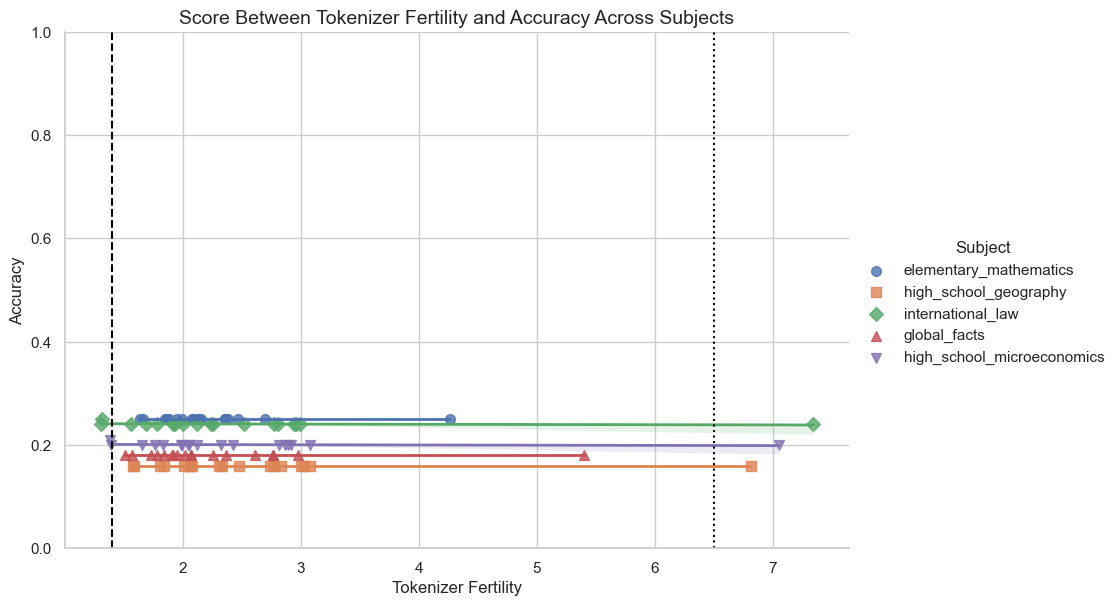

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Create the scatterplot with regression lines for each subject
g = sns.lmplot(
    data=all_languages_df,
    x="Fertility",
    y="Accuracy",
    hue="Subject",
    height=6,
    aspect=1.5,
    scatter_kws={"s": 50},  # Adjust scatter point size
    line_kws={"linewidth": 2},  # Adjust regression line width
    markers=["o", "s", "D", "^", "v"],  # Different markers for subjects
)

# Set y-axis limits
g.ax.set_ylim(0, 1)

# Add vertical lines for English (low fertility) and another reference language (high fertility)
plt.axvline(x=1.4, color="black", linestyle="--", label="Low Fertility (English)")
plt.axvline(x=6.5, color="black", linestyle=":", label="High Fertility (Amharic)")

# Add labels and title
plt.title("Score Between Tokenizer Fertility and Accuracy Across Subjects", fontsize=14)
plt.xlabel("Tokenizer Fertility", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Adjust legend
plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

25% Scores bascially mean its guessing at random, so we need a better model to actually get any of these tasks.